# Rule Based: Full vs Partial Conditional

In [1]:
## Load Packages
using Omega
using StatsBase
using Random
using Plots
using Distributions
using PyCall
using DataStructures

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1192
┌ Warning: Module JSON with build ID 28048663874804 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192
rec_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\stackwalk.c:94
record_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:246
jl_throw at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:577
jl_bounds_error_ints at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64

## Build Model

### Load SBML

In [7]:
function get_parameters(sbml_file_path)
        
    """
    Function to extract model parameters from sbml. Returns dictionary with 
    a transition matrix, species list, and rates list.
    """
    ## Load SBML
    sbml = te.loadSBMLModel(sbml_file_path)

    ## Transition Matrix
    transition = sbml.getFullStoichiometryMatrix()
    transition = transpose(transition)
    
    ## Extract Species
    species_ids = sbml.getFloatingSpeciesIds()
    species_starting_vals = sbml.getFloatingSpeciesAmounts()
    species = Dict(species_ids .=> species_starting_vals)
    
    ## Extract Rates
    rates = Dict(sbml.getGlobalParameterIds() .=> sbml.getGlobalParameterValues())
    
    return Dict("transition" => transition, "species" => species, "rates" => rates)
    
end

get_parameters (generic function with 1 method)

In [15]:
te = pyimport("tellurium")
model_params = get_parameters("../SBML_Models/Kappa_resimulationmodel_sbml_KaDE.sbml")
sbml = te.loadSBMLModel("../SBML_Models/Kappa_resimulationmodel_sbml_KaDE.sbml")
t = vcat(model_params["transition"], [0 0 0 0 0 0 0 0])
species = model_params["species"]
rates = model_params["rates"]
print()

### Random Variables

In [16]:
function reaction_gen(rng, n, theta)
    
    ecology = OrderedDict("s1" => S1_vals[n], "s2" => S2_vals[n], "s3" => S3_vals[n], 
        "s4" => S4_vals[n], "s5" => S5_vals[n], "s6" => S6_vals[n], "s7" => S7_vals[n], 
        "s8" => S8_vals[n])
    
    haz = OrderedDict(sbml.getReactionIds() .=> [
        ecology["s3"]*theta["mod_rate_slow"],
        ecology["s3"]*theta["off_rate_fast"],
        ecology["s3"]*theta["mod_rate"],
        ecology["s8"]*theta["mod_rate_slow"],
        ecology["s8"]*theta["off_rate_fast"],
        (1/theta["VA"])*(ecology["s7"]*ecology["s1"]),
        (1/theta["VA"])*(ecology["s7"]*ecology["s4"]),
        ecology["s6"]*theta["off_rate_slow"],
        ecology["s5"]*theta["off_rate_slow"],
        ecology["s5"]*theta["mod_rate"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s4"]),
        ecology["s1"]*theta["mod_rate_slow"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s1"])]
        )
    
    for (key, val) in haz
        if val < 0
            haz[key] = 0 - value
        end
    end
    
    ## Get values from hazard dictionary
    vals = collect(values(haz))
    sum_vals = sum(vals)
    ## Calculate probabilities
    prob_vals = vals/sum_vals
    ## Sample
    hazard_result = categorical(rng, prob_vals)

    return hazard_result
end

function time_gen(rng, n, theta)
    
    ecology = OrderedDict("s1" => S1_vals[n], "s2" => S2_vals[n], "s3" => S3_vals[n], 
        "s4" => S4_vals[n], "s5" => S5_vals[n], "s6" => S6_vals[n], "s7" => S7_vals[n], 
        "s8" => S8_vals[n])
    
    haz = OrderedDict(sbml.getReactionIds() .=> [
        ecology["s3"]*theta["mod_rate_slow"],
        ecology["s3"]*theta["off_rate_fast"],
        ecology["s3"]*theta["mod_rate"],
        ecology["s8"]*theta["mod_rate_slow"],
        ecology["s8"]*theta["off_rate_fast"],
        (1/theta["VA"])*(ecology["s7"]*ecology["s1"]),
        (1/theta["VA"])*(ecology["s7"]*ecology["s4"]),
        ecology["s6"]*theta["off_rate_slow"],
        ecology["s5"]*theta["off_rate_slow"],
        ecology["s5"]*theta["mod_rate"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s4"]),
        ecology["s1"]*theta["mod_rate_slow"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s1"])]
        )
    
    haz_sum = sum([abs(x) for x in values(haz)])
    update = exponential(rng, haz_sum)
    time_val = time_list[n](rng) + update
    
    return time_val
end

function deterministic_updater(rng, n, transition, theta)

    ecology = OrderedDict("s1" => S1_vals[n], "s2" => S2_vals[n], "s3" => S3_vals[n], 
        "s4" => S4_vals[n], "s5" => S5_vals[n], "s6" => S6_vals[n], "s7" => S7_vals[n], 
        "s8" => S8_vals[n])
    
    haz = OrderedDict(sbml.getReactionIds() .=> [
        ecology["s3"]*theta["mod_rate_slow"],
        ecology["s3"]*theta["off_rate_fast"],
        ecology["s3"]*theta["mod_rate"],
        ecology["s8"]*theta["mod_rate_slow"],
        ecology["s8"]*theta["off_rate_fast"],
        (1/theta["VA"])*(ecology["s7"]*ecology["s1"]),
        (1/theta["VA"])*(ecology["s7"]*ecology["s4"]),
        ecology["s6"]*theta["off_rate_slow"],
        ecology["s5"]*theta["off_rate_slow"],
        ecology["s5"]*theta["mod_rate"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s4"]),
        ecology["s1"]*theta["mod_rate_slow"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s1"])]
        )
    

    reaction = reaction_list[n](rng)

    update_val = deepcopy(transition[reaction, :])
    id = collect(keys(haz))[reaction]
    
    if haz[id] < 0
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    insert!(S1_vals, n + 1, ecology["s1"] + update_val[1])
    insert!(S2_vals, n + 1, ecology["s2"] + update_val[2])
    insert!(S3_vals, n + 1, ecology["s3"] + update_val[3])
    insert!(S4_vals, n + 1, ecology["s4"] + update_val[4])
    insert!(S5_vals, n + 1, ecology["s5"] + update_val[5])
    insert!(S6_vals, n + 1, ecology["s6"] + update_val[6])
    insert!(S7_vals, n + 1, ecology["s7"] + update_val[7])
    insert!(S8_vals, n + 1, ecology["s8"] + update_val[8])
    
    return reaction
end

deterministic_updater (generic function with 1 method)

### Unconditioned Simulation

In [17]:
## Initialize lists to hold random variables and species values
global time_list = Any[]; global reaction_list = Any[]; global update_list = Any[]

global S1_vals = []; global S2_vals = []; global S3_vals = []
global S4_vals = []; global S5_vals = []; global S6_vals = []
global S7_vals = []; global S8_vals = []

## Insert starting species values
#insert!(S0_list, 1, normal(species["__s0"], .00001))
push!(S1_vals, species["s1"])
push!(S2_vals, species["s2"])
push!(S3_vals, species["s3"])
push!(S4_vals, species["s4"])
push!(S5_vals, species["s5"])
push!(S6_vals, species["s6"])
push!(S7_vals, species["s7"])
push!(S8_vals, species["s8"])
insert!(time_list, 1, uniform([0]))

## Create random variables for each step
for f in 2:10
    last = f - 1
    push!(reaction_list, ciid(reaction_gen, last, rates))
    push!(time_list, ciid(time_gen, last, rates))
    push!(update_list, ciid(deterministic_updater, last, t, rates))
end

rv = (Tuple(update_list)..., Tuple(time_list)...)
print()

In [48]:
## Sample
Random.seed!(15)
samples = rand(rv, 1, alg = RejectionSample)
print()

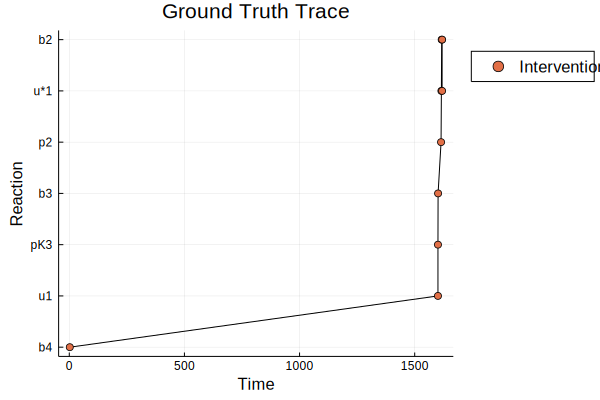

In [49]:
map_dict = OrderedDict(1 => "pK1", 2 => "u1", 3 => "p1", 4 => "pK2",
    5 => "u2", 6 => "b1", 7 => "b2", 8 => "u*1", 9 => "u*2", 
    10 => "p2", 11 => "b3", 12 => "pK3", 13 => "b4", 14 => "NoReaction")
simple_labels = [map_dict[i] for i in samples[1][1:9]]

plot([x for x in samples[1][11:19]], simple_labels,
        linecolor = ["black"], label = false)
plot!([x for x in samples[1][11:19]], simple_labels,
        title = "Ground Truth Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

## Full Conditional

In [71]:
## Initialize lists to hold random variables and species values
global time_list = Any[]; global reaction_list = Any[]; global update_list = Any[]

global S1_vals = []; global S2_vals = []; global S3_vals = []
global S4_vals = []; global S5_vals = []; global S6_vals = []
global S7_vals = []; global S8_vals = []

## Condition vals
condition = [[x for x in samples[1][1:9]], [x for x in samples[1][11:19]]]

## Insert starting species values
push!(S1_vals, species["s1"])
push!(S2_vals, species["s2"])
push!(S3_vals, species["s3"])
push!(S4_vals, species["s4"])
push!(S5_vals, species["s5"])
push!(S6_vals, species["s6"])
push!(S7_vals, species["s7"])
push!(S8_vals, species["s8"])
insert!(time_list, 1, uniform([0]))

## Create random variables for each step
for f in 2:10
    
    last = f - 1
    temp_rv = ciid(reaction_gen, last, rates)
    temp_rv = cond(temp_rv, temp_rv ==ₛ condition[1][last])
    push!(reaction_list, temp_rv)
    
    temp_time = ciid(time_gen, last, rates)
    temp_time = cond(temp_time, temp_time ==ₛ condition[2][last])
    push!(time_list, temp_time)

    push!(update_list, ciid(deterministic_updater, last, t, rates))
end

condition_rv = (Tuple(update_list)..., Tuple(time_list)...)
print()

Replace pK event

In [72]:
reaction_list[3] = replace(reaction_list[3], reaction_list[3] => 13)

4407:getfield(Omega, Symbol("##6#7")){Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(reaction_gen),Int64,Dict{String,Float64}}},Omega.URandVar{typeof(Omega.liftreifyapply),Tuple{typeof(softeq),Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(reaction_gen),Int64,Dict{String,Float64}}},Float64}}}(4405:Omega.reifyapply(reaction_gen, 3, Dict("off_rate_slow"=>1.0,"off_rate_fast"=>1000.0,"period"=>0.01,"VA"=>1.0,"mod_rate_slow"=>0.05,"tend"=>1.0,"mod_rate"=>5.0,"tinit"=>0.0))::Any, 4406:Omega.liftreifyapply(Omega.Soft.softeq, Omega.reifyapply, 12.0)::Any)()::Any | intervened 

In [53]:
int_cond_samples = rand(condition_rv, 5000, alg = Replica)

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]
plast = -0.09153108892891437
Chain at temp 2.061153622438558e-9 Failed due to:TypeError(Symbol("#memrand#38"), "typeassert", Int64, 2.1423293973552232e-5)
plast = -6265.156994559945
plast = -2.224970108208985e7
Chain at temp 1.0 Failed due to:TypeError(Symbol("#memrand#38"), "typeassert", Int64, 6.547523517605751e-6)
plast = -8.396922517773958e10
plast = -0.2844376875039622
plast = -2016.1063994541441
plast = -2.224970108208985e7
plast = -8.396236501933482e10
plast = -0.29437181295939485
plast = -2016.1063994541441
plast = -1.587075089895071e7
plast = -8.396236501933482e10
plast = -0.29437181295939485
plast = -2016.1063994541441
plast = -1.587075089895071e7
plast = -8.396236501933482e10
plast = -0.21245421513523177
plast = -1876.5173891007566
plast = -1.587075089895071e7
plast = -8.396236501933482e10
plast = -0.21245421513523177
plast = -1676.5452901542799
plast = -1.587075089895071e7
plast = -8.396236501933482e10
plast = -0.21245421513523

1884-element Array{Tuple{Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64},1}:
 (13, 2, 13, 2, 13, 2, 13, 2, 13, 0, 0.26721926236587773, 503.0497189553404, 503.24125143667595, 795.8155028054755, 796.5028584975765, 1586.6259965054883, 1587.435340048077, 1820.5450406418042, 1820.8881784182547)  
 (13, 2, 13, 2, 13, 2, 13, 2, 13, 0, 0.26721926236587773, 503.0497189553404, 503.24125143667595, 795.8155028054755, 796.5028584975765, 1586.6259965054883, 1587.435340048077, 1820.5450406418042, 1820.8881784182547)  
 (13, 2, 13, 2, 13, 2, 13, 2, 13, 0, 0.26721926236587773, 503.0497189553404, 503.24125143667595, 795.8155028054755, 796.5028584975765, 1586.6259965054883, 1587.435340048077, 1820.5450406418042, 1820.8881784182547)  
 (13, 2, 13, 2, 13, 2, 13, 2, 13, 0, 0.26721926236587773, 503.0497189553404, 503.24125143667595, 795.8155028054755, 796.5028584975765, 1586.6259965054883, 1587.435340048077, 1820.54504064180

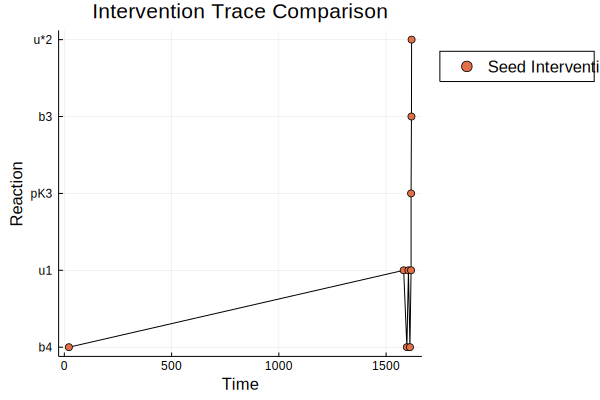

In [54]:
int_condition_labels = [map_dict[i] for i in last(int_cond_samples)[1:9]]

plot([x for x in last(int_cond_samples)[11:19]], 
    int_condition_labels,
        linecolor = ["black"], label = false)
plot!([x for x in last(int_cond_samples)[11:19]], 
    int_condition_labels,
        title = "Intervention Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Seed Intervention" "Conditioned Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

We can see one fully conditioned event, but what happens if we were to run it multiple times?

This takes a while so only ran 3 times

In [91]:
plot_array = Any[]

for x in 1:3
    temp_int_cond_samples = rand(condition_rv, 5000, alg = Replica)
    
    temp_int_condition_labels = [map_dict[i] for i in last(temp_int_cond_samples)[1:9]]

    push!(plot_array, last(temp_int_cond_samples))
end

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]
plast = -0.21141618419014863
plast = -4664.296250691178
plast = -4.333318637120828e7
plast = -1.421826736449903e11
plast = -0.21175872217280092
plast = -4656.751349532864
plast = -4.333318637120828e7
plast = -1.421826736449903e11
plast = -0.19759336143852438
plast = -3763.9864017640584
plast = -4.333226383841807e7
plast = -1.4217527397019864e11
plast = -0.19759336143852438
plast = -3763.9864017640584
plast = -4.333226383841807e7
plast = -1.4216832828878577e11
plast = -0.19759336143852438
plast = -3200.3940423143576
plast = -4.333226383841807e7
plast = -1.4216832828878577e11
plast = -0.19760622578220496
Chain at temp 2.061153622438558e-9 Failed due to:TypeError(Symbol("#memrand#38"), "typeassert", Int64, 1.3738150612037496e-5)
plast = -3200.3940423143576
plast = -4.333145720894805e7
Chain at temp 1.0 Failed due to:TypeError(Symbol("#memrand#38"), "typeassert", Int64, 9.197933602200888e-6)
plast = -1.4216832828878577e11
plast = -0.1976062257

Excessive output truncated after 524294 bytes.


plast = -3.42970096570611e7
plast = -0.017852475192983653
plast = -0.21263085815714652
Chain at temp 4.539992976248485e-5 Failed due to:

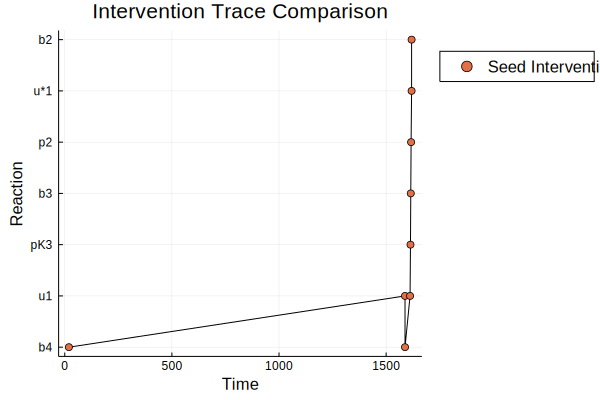

In [92]:
temp_int_condition_labels = [map_dict[i] for i in plot_array[1][1:9]]

plot([x for x in plot_array[1][11:19]], 
    temp_int_condition_labels,
        linecolor = ["black"], label = false)
plot!([x for x in plot_array[1][11:19]], 
    temp_int_condition_labels,
        title = "Intervention Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Seed Intervention" "Conditioned Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

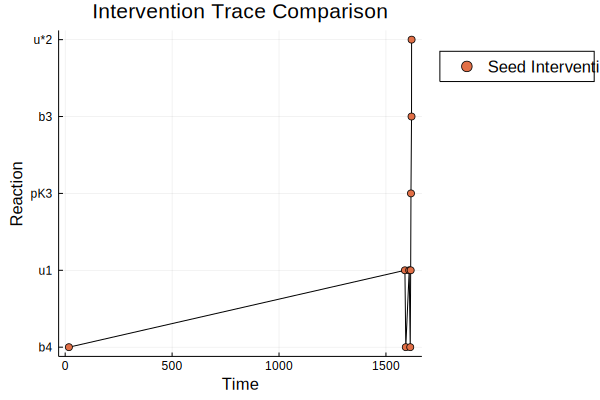

In [93]:
temp_int_condition_labels = [map_dict[i] for i in plot_array[2][1:9]]

plot([x for x in plot_array[2][11:19]], 
    temp_int_condition_labels,
        linecolor = ["black"], label = false)
plot!([x for x in plot_array[2][11:19]], 
    temp_int_condition_labels,
        title = "Intervention Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Seed Intervention" "Conditioned Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

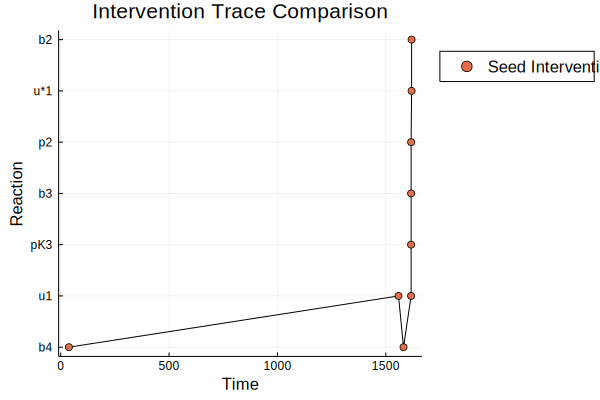

In [94]:
temp_int_condition_labels = [map_dict[i] for i in plot_array[3][1:9]]

plot([x for x in plot_array[3][11:19]], 
    temp_int_condition_labels,
        linecolor = ["black"], label = false)
plot!([x for x in plot_array[3][11:19]], 
    temp_int_condition_labels,
        title = "Intervention Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Seed Intervention" "Conditioned Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

## Partial Conditional

In [113]:
## Initialize lists to hold random variables and species values
global time_list = Any[]; global reaction_list = Any[]; global update_list = Any[]

global S1_vals = []; global S2_vals = []; global S3_vals = []
global S4_vals = []; global S5_vals = []; global S6_vals = []
global S7_vals = []; global S8_vals = []

## Condition vals
condition = [[x for x in samples[1][1:9]], [x for x in samples[1][11:19]]]

## Insert starting species values
push!(S1_vals, species["s1"])
push!(S2_vals, species["s2"])
push!(S3_vals, species["s3"])
push!(S4_vals, species["s4"])
push!(S5_vals, species["s5"])
push!(S6_vals, species["s6"])
push!(S7_vals, species["s7"])
push!(S8_vals, species["s8"])
insert!(time_list, 1, uniform([0]))

## Create random variables for each step
for f in 2:10
    
    last = f - 1
    if last < 4
        temp_rv = ciid(reaction_gen, last, rates)
        temp_rv = cond(temp_rv, temp_rv ==ₛ condition[1][last])
        push!(reaction_list, temp_rv)

        temp_time = ciid(time_gen, last, rates)
        temp_time = cond(temp_time, temp_time ==ₛ condition[2][last])
        push!(time_list, temp_time)
    else
        push!(reaction_list, ciid(reaction_gen, last, rates))
        push!(time_list, ciid(time_gen, last, rates))
    end
    
    push!(update_list, ciid(deterministic_updater, last, t, rates))
end

partial_condition_rv = (Tuple(update_list)..., Tuple(time_list)...)
print()

In [114]:
reaction_list[3] = replace(reaction_list[3], reaction_list[3] => 13)

44356:getfield(Omega, Symbol("##6#7")){Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(reaction_gen),Int64,Dict{String,Float64}}},Omega.URandVar{typeof(Omega.liftreifyapply),Tuple{typeof(softeq),Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(reaction_gen),Int64,Dict{String,Float64}}},Float64}}}(44354:Omega.reifyapply(reaction_gen, 3, Dict("off_rate_slow"=>1.0,"off_rate_fast"=>1000.0,"period"=>0.01,"VA"=>1.0,"mod_rate_slow"=>0.05,"tend"=>1.0,"mod_rate"=>5.0,"tinit"=>0.0))::Any, 44355:Omega.liftreifyapply(Omega.Soft.softeq, Omega.reifyapply, 12.0)::Any)()::Any | intervened 

In [60]:
partial_cond_samples = rand(partial_condition_rv, 2000, alg = Replica)

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]
plast = -0.0011502162228376309
plast = -120.47016560509667
plast = -531071.876657028
plast = -9.174132864461444e10
plast = -0.008584807641167591
Chain at temp 2.061153622438558e-9 Failed due to:TypeError(Symbol("#memrand#38"), "typeassert", Int64, 1.068994132467118e-5)
plast = -25.335198288964854
plast = -2.653531981995363e6
plast = -1.169763652576984e10
plast = -0.008584807641167591
plast = -120.47016560509667
plast = -558039.6741078864
plast = -1.169763652576984e10
plast = -0.008584807641167591
plast = -120.47016560509667
plast = -558039.6741078864
plast = -1.169763652576984e10
plast = -0.008584807641167591
plast = -120.47016560509667
plast = -557565.8850924091
plast = -1.169763652576984e10
plast = -0.008584807641167591
plast = -120.47016560509667
plast = -557565.8850924091
plast = -1.169763652576984e10
plast = -0.005469337056946308
plast = -3.971900203935415
plast = -557565.8850924091
plast = -1.169763652576984e10
plast = -0.00546933705

1883-element Array{Tuple{Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64},1}:
 (13, 2, 13, 2, 13, 2, 13, 2, 13, 0, 2.0257391276482606, 3043.625107877048, 3044.456677552937, 4688.858636551692, 4689.208626360147, 5483.456088912119, 5484.589982751628, 5642.418393315905, 5644.568528476329)    
 (13, 2, 13, 2, 13, 2, 13, 2, 13, 0, 0.9663086992226025, 2116.1934760162108, 2116.299278012545, 5394.378031717071, 5395.304386363401, 5702.6689379510235, 5705.236590020598, 5981.988993537748, 5982.271410628672)  
 (13, 2, 13, 2, 13, 2, 13, 2, 13, 0, 0.9663086992226025, 2116.1934760162108, 2116.299278012545, 5394.378031717071, 5395.304386363401, 5702.6689379510235, 5705.236590020598, 5981.988993537748, 5982.320063366915)  
 (13, 2, 13, 2, 13, 2, 13, 2, 13, 0, 0.9663086992226025, 2116.1934760162108, 2116.299278012545, 5394.378031717071, 5395.304386363401, 5702.6689379510235, 5705.236590020598, 5981.988993537748, 5982.32

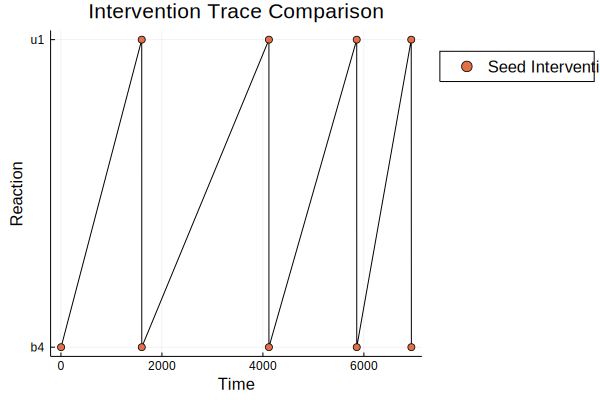

In [61]:
partial_cond_samples = rand(partial_condition_rv, 2000, alg = Replica)
partial_condition_labels = [map_dict[i] for i in last(partial_cond_samples)[1:9]]

plot([x for x in last(partial_cond_samples)[11:19]], 
    partial_condition_labels,
        linecolor = ["black"], label = false)
plot!([x for x in last(partial_cond_samples)[11:19]], 
    partial_condition_labels,
        title = "Intervention Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Seed Intervention" "Conditioned Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

We see that the trace is significantly different from the fully conditioned trace other than the first three variables. Again what happens when multiple traces are run?

In [97]:
partial_plot_array = Any[]

for x in 1:3
    temp_int_cond_samples = rand(partial_condition_rv, 5000, alg = Replica)

    push!(partial_plot_array, last(temp_int_cond_samples))
end

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]
plast = -0.0032469148876462166
plast = -19.23469566127106
plast = -1.2252467793866564e7
Chain at temp 1.0 Failed due to:TypeError(Symbol("#memrand#38"), "typeassert", Int64, 1.3161914283696288e-5)
plast = -1.4800082213224112e10
plast = -0.025254218377139835
plast = -71.51805971138808
plast = -423672.3660565043
plast = -1.4800082213224112e10
plast = -0.025254218377139835
plast = -71.51805971138808
plast = -671922.6929593759
plast = -9.332004879148422e9
plast = -0.025254218377139835
plast = -71.51805971138808
plast = -671922.6929593759
plast = -9.332004879148422e9
plast = -0.02525479873885858
plast = -71.51805971138808
plast = -671922.6929593759
plast = -9.332004879148422e9
plast = -0.02525479873885858
plast = -71.51805971138808
plast = -671922.6929593759
plast = -9.332004879148422e9
plast = -0.02525479873885858
plast = -71.51805971138808
plast = -671922.6929593759
plast = -9.332004879148422e9
plast = -0.02525479873885858
plast = -71.5180597

Excessive output truncated after 524291 bytes.

plast = -0.0011592679277602695
plast = -0.2195088186634922
plast = -15.093764446266217


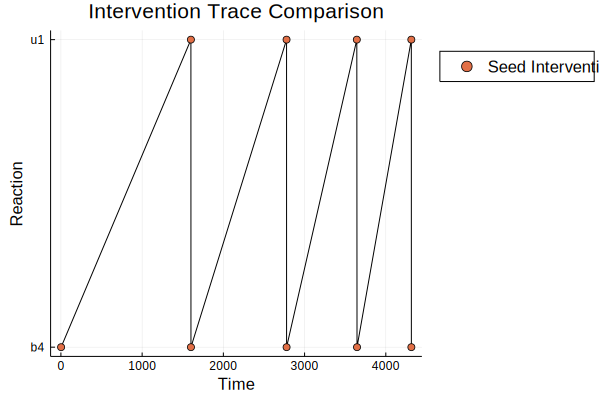

In [98]:
temp_int_condition_labels = [map_dict[i] for i in partial_plot_array[1][1:9]]

plot([x for x in partial_plot_array[1][11:19]], 
    temp_int_condition_labels,
        linecolor = ["black"], label = false)
plot!([x for x in partial_plot_array[1][11:19]], 
    temp_int_condition_labels,
        title = "Intervention Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Seed Intervention" "Conditioned Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

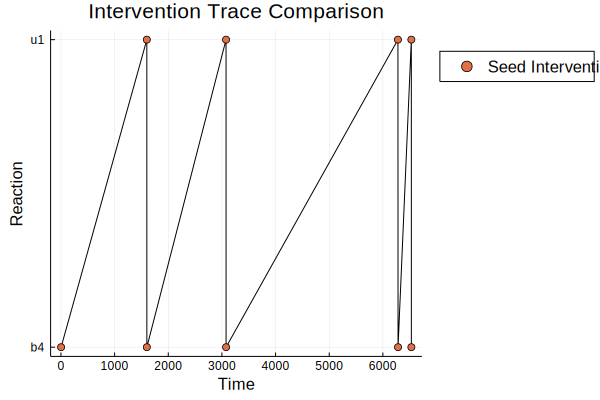

In [99]:
temp_int_condition_labels = [map_dict[i] for i in partial_plot_array[2][1:9]]

plot([x for x in partial_plot_array[2][11:19]], 
    temp_int_condition_labels,
        linecolor = ["black"], label = false)
plot!([x for x in partial_plot_array[2][11:19]], 
    temp_int_condition_labels,
        title = "Intervention Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Seed Intervention" "Conditioned Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

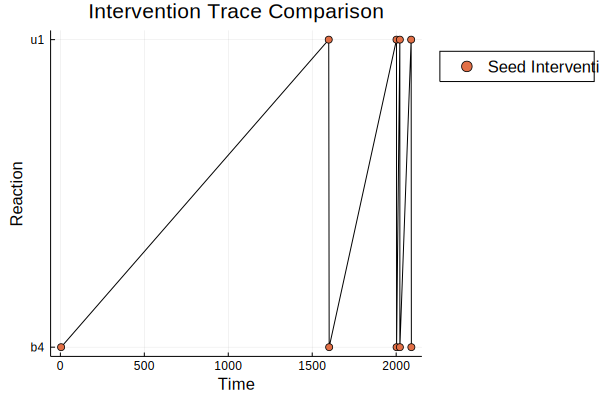

In [100]:
temp_int_condition_labels = [map_dict[i] for i in partial_plot_array[3][1:9]]

plot([x for x in partial_plot_array[3][11:19]], 
    temp_int_condition_labels,
        linecolor = ["black"], label = false)
plot!([x for x in partial_plot_array[3][11:19]], 
    temp_int_condition_labels,
        title = "Intervention Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Seed Intervention" "Conditioned Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

In [107]:
partial_cond_samples = rand(partial_condition_rv, 2000, alg = Replica)
partial_condition_labels = [map_dict[i] for i in last(partial_cond_samples)[1:9]]
print()

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]
plast = -0.003922299710267971
plast = -81.07428739510866
plast = -3.6784093931510923e6
plast = -4.997344581296942e9
plast = -0.007581766845505391
plast = -86.39440040519776
plast = -1.78578001814669e6
Chain at temp 1.0 Failed due to:TypeError(Symbol("#memrand#38"), "typeassert", Int64, 3.5540308992108063e-6)
plast = -4.997344581296942e9
plast = -0.007581734793917757
plast = -86.39440040519776
plast = -1.78578001814669e6
plast = -4.997344581296942e9
plast = -0.007581734793917757
plast = -86.39440040519776
plast = -1.78578001814669e6
plast = -4.997344581296942e9
plast = -0.007581734793917757
plast = -86.39440040519776
plast = -1.78578001814669e6
plast = -4.997344581296942e9
plast = -0.007581734793917757
plast = -86.39440040519776
plast = -1.78578001814669e6
plast = -4.997344581296942e9
plast = -0.007581734793917757
plast = -86.39440040519776
plast = -280225.9489859247
Chain at temp 1.0 Failed due to:TypeError(Symbol("#memrand#38"), "typeasse

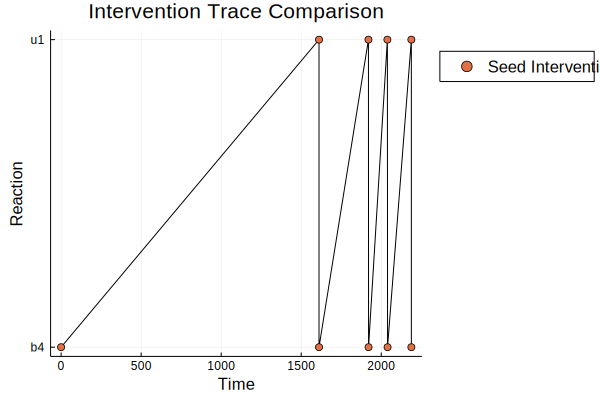

In [108]:
plot([x for x in last(partial_cond_samples)[11:19]], 
    partial_condition_labels,
        linecolor = ["black"], label = false)
plot!([x for x in last(partial_cond_samples)[11:19]], 
    partial_condition_labels,
        title = "Intervention Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Seed Intervention" "Conditioned Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

In [117]:
Random.seed!(10)
partial_cond_samples = rand(partial_condition_rv, 2000, alg = Replica)
partial_condition_labels = [map_dict[i] for i in last(partial_cond_samples)[1:9]]
print()

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]
plast = -0.0009687784316620837
plast = -196.55255005450033
plast = -4.736152684890395e6
plast = -5.803085193111123e9
plast = -0.009761938262883942
plast = -21.33876498775138
plast = -4.329358020657487e6
plast = -5.803085193111123e9
plast = -0.009761938262883942
plast = -196.55255005450033
plast = -470017.57710612495
plast = -5.803085193111123e9
plast = -0.009761938262883942
plast = -196.55255005450033
plast = -470017.57710612495
plast = -5.803085193111123e9
plast = -0.009761938262883942
plast = -196.55255005450033
plast = -470017.57710612495
plast = -5.803085193111123e9
plast = -0.009761938262883942
plast = -196.55255005450033
plast = -470017.57710612495
plast = -5.803085193111123e9
plast = -0.009761938262883942
plast = -196.49500221070608
plast = -470017.57710612495
plast = -5.803085193111123e9
plast = -0.009761938262883942
plast = -196.49500221070608
plast = -470017.57710612495
plast = -5.803085193111123e9
plast = -0.009761938262883942
p

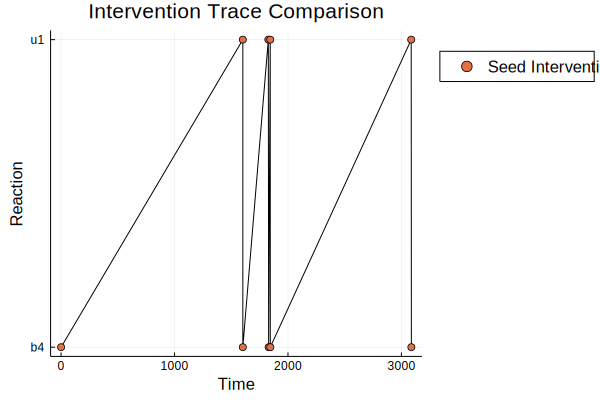

In [118]:
plot([x for x in last(partial_cond_samples)[11:19]], 
    partial_condition_labels,
        linecolor = ["black"], label = false)
plot!([x for x in last(partial_cond_samples)[11:19]], 
    partial_condition_labels,
        title = "Intervention Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Seed Intervention" "Conditioned Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)